In [66]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import glob, re

import sys
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib import colors

sys.path.append('../../src')
from m3_learning.RHEED.Analysis_umich import fit_curves, plot_activation_energy, select_range
from m3_learning.RHEED.Analysis import detect_peaks, process_rheed_data, fit_exp_function, process_curves
from m3_learning.viz.layout import layout_fig
from m3_learning.RHEED.Viz import Viz

from scipy.optimize import curve_fit
# use simplified version to avoid overfitting to wrong fitting function
def taylor_expansion(x, b, tau):
    # return b - (np.exp(-x/tau) + np.exp(-x/(tau))**2/2 - np.exp(-x/(tau))**3/3 + np.exp(-x/(tau))**4/4 - np.exp(-x/(tau))**5/5 + np.exp(-x/(tau))**6/6 - np.exp(-x/(tau))**7/7 + np.exp(-x/(tau))**8/8 - np.exp(-x/(tau))**9/9 + np.exp(-x/(tau))**10/10)
    return b - np.exp(-x/tau)
    
def puiseux_series(x, b, tau):
    return b + np.log(x/tau) - x/(2*tau) 

def fit_tau(xs, ys, func, normalize_params):

    p_init = normalize_params['p_init']
    bounds = normalize_params['bounds']


    b_list, tau_list, ys_log_fit, ys_log, ys_fit, labels, labels_log = [], [], [], [], [], [], []
    for i, (x, y) in enumerate(zip(xs, ys)):
        x_nor = x - x[0]

        # y0 = np.max( [np.mean(y[-3:]), np.max(y[-3:])] )
        # y_nor_log = np.log((y/y0))
        y_init = np.min(y[:3])
        y_nor = y - y_init
        y_nor = [y if y > 1 else 1 for y in y_nor]
        y_nor_log = np.log(y_nor)
        # y_nor_log = np.log(y)

        # plt.plot(x_nor, y_nor_log)
        # plt.show()
        if func == 'taylor_expansion':
            params, params_covariance = curve_fit(taylor_expansion, x_nor, y_nor_log, p0=p_init, bounds=bounds, absolute_sigma=False)
        elif func == 'puiseux_series':
            params, params_covariance = curve_fit(puiseux_series, x_nor, y_nor_log, p0=p_init, bounds=bounds, absolute_sigma=False)
        # params, params_covariance = curve_fit(func, x_nor, y_nor_log, absolute_sigma=False) 
        b, tau = params

        if func == 'taylor_expansion':
            y_fit = taylor_expansion(x_nor, b, tau)
            labels_log.append(f'index {i+1}:\nlnI={b:.2f}-exp(-t/{tau:.2f})')
            labels.append(f'index {i+1}:\nI={np.exp(b):.2E}[1-exp(-t/{tau:.2f})]')
        elif func == 'puiseux_series':
            y_fit = puiseux_series(x_nor, b, tau)
            labels.append(f'index {i+1}:\nlnI={b:.2f}-[ln(t/2{tau:.2f})-t/(2{tau:.2f})]')

        b_list.append(b)
        tau_list.append(tau)
        ys_log.append(y_nor_log)
        ys_log_fit.append(y_fit)
        ys_fit.append(np.exp(y_fit))

# b - ( np.log(x/tau) + x/(2*tau) - x**2/(24*tau**2) )
    return b_list, tau_list, ys_log_fit, ys_fit, ys_log, labels_log, labels



def analyze_rheed_data_txt(data, camera_freq, laser_freq, 
        denoise_params = {'savgol_window_order': (51,3), 'pca_component': None, 'fft_cutoff_order':(20, 1), 'median_kernel_size':51},
        curve_params = {'trim_first':0, 'tune_tail':True, 'convolve_step':5, 'prominence':0.8, 'mode':'full', 'linear_ratio':0.8},
        normalize_params = {'I_diff': None, 'unify':True, 'bounds':[0.01, 1], 'p_init':(1, 0.1, 0.4), 'n_std':1},
        viz_params = {'viz_denoise': True, 'viz_curves': False, 'viz_fittings': False, 'viz_ab': False}):

    if isinstance(data, str):
        data = np.loadtxt(data)
    sample_x, sample_y = data[:,0], data[:,1]
    
    # denoise
    sample_x, sample_y = process_rheed_data(sample_x, sample_y, camera_freq, denoise_params, viz_params['viz_denoise'])       

    # detect peaks
    # print(sample_y[0].shape, sample_y[1].shape)
    x_peaks, xs, ys = detect_peaks(sample_x, sample_y, camera_freq=camera_freq, laser_freq=laser_freq, curve_params=curve_params)

    # denoise
    xs, ys = process_curves(xs, ys, curve_params)        

    # viz curves
    if viz_params['viz_curves']:
        xs_sample, ys_sample = xs[::1], ys[::1]
        fig, axes = layout_fig(len(ys_sample), mod=6, figsize=(12,2*len(ys_sample)//6+1), layout='compressed')
        Viz.show_grid_plots(axes, xs_sample, ys_sample, labels=None, xlabel=None, ylabel=None, ylim=None, legend=None, color=None)

    # fit exponential function
    b_list, tau_list, ys_log_fit, ys_fit, ys_log, labels_log, labels = fit_tau(xs, ys, func='taylor_expansion', normalize_params=normalize_params)

    # viz fittings
    if viz_params['viz_fittings']:
        Viz.plot_fit_details(xs, ys_log, ys_log_fit, y3=None, labels=labels_log, figsize=(10, 1.8*len(xs)//4+1), mod=4, style='presentation', logscale=False)
        Viz.plot_fit_details(xs, ys, ys_fit, y3=None, labels=labels, figsize=(10, 1.8*len(xs)//4+1), mod=4, style='presentation', logscale=False)  
    return b_list, tau_list, ys_log_fit, ys_fit, ys_log, labels_log, labels


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


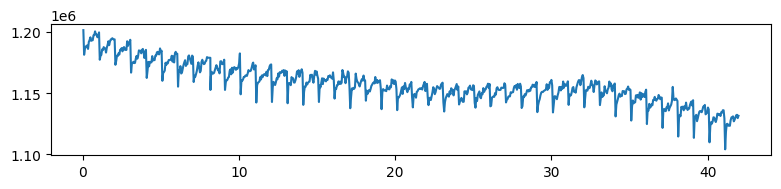

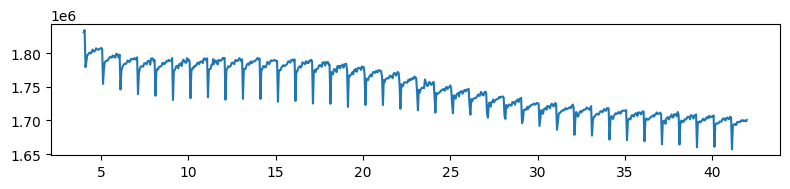

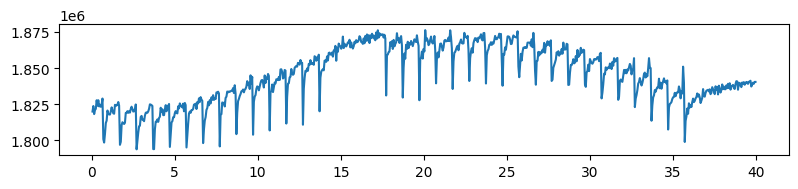

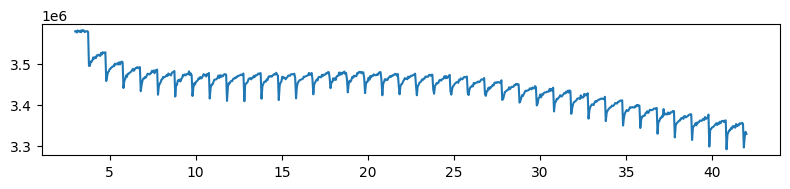

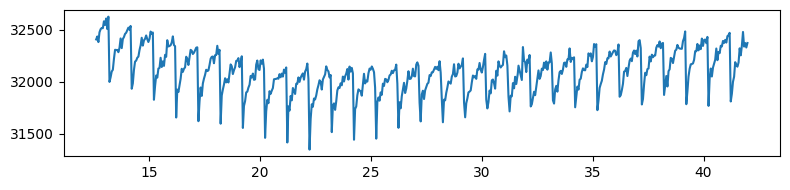

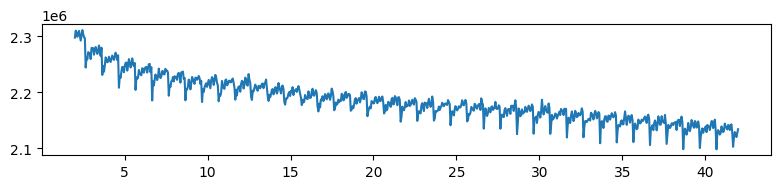

In [64]:
ranges_list = [(0, 42), (4, 42), (0, 40), (3, 42), (0, 42), (2, 42)]
files = glob.glob('./Saved_data/rheed_data/selected/*.txt')

for file, ranges in zip(files, ranges_list):
    data = np.loadtxt(file)
    data = select_range(data, *ranges)

    plt.subplots(1, 1, figsize=(8,2))
    plt.plot(data[:,0], data[:,1])
    plt.tight_layout()
    plt.show()

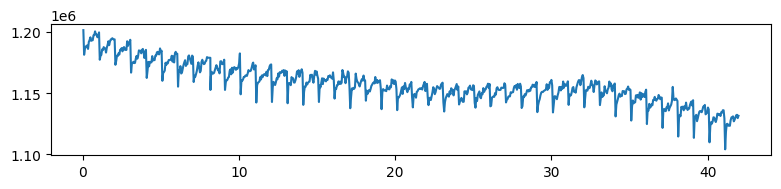

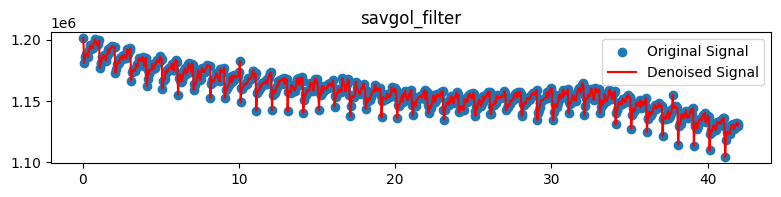

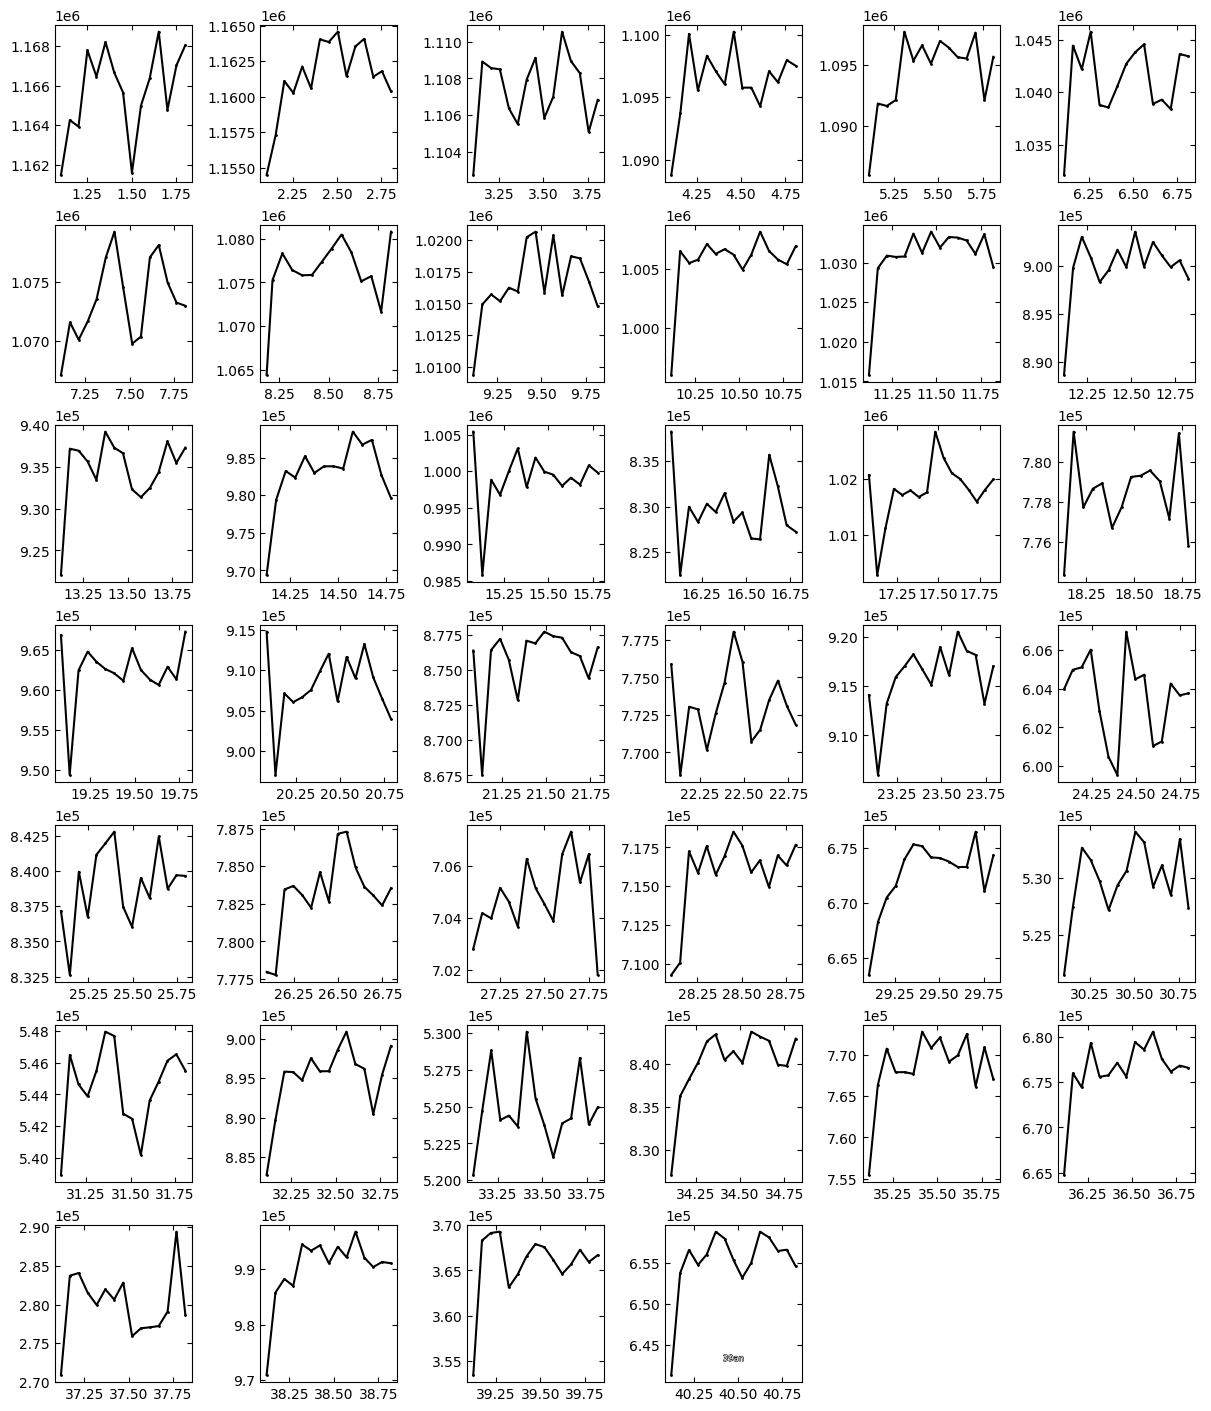

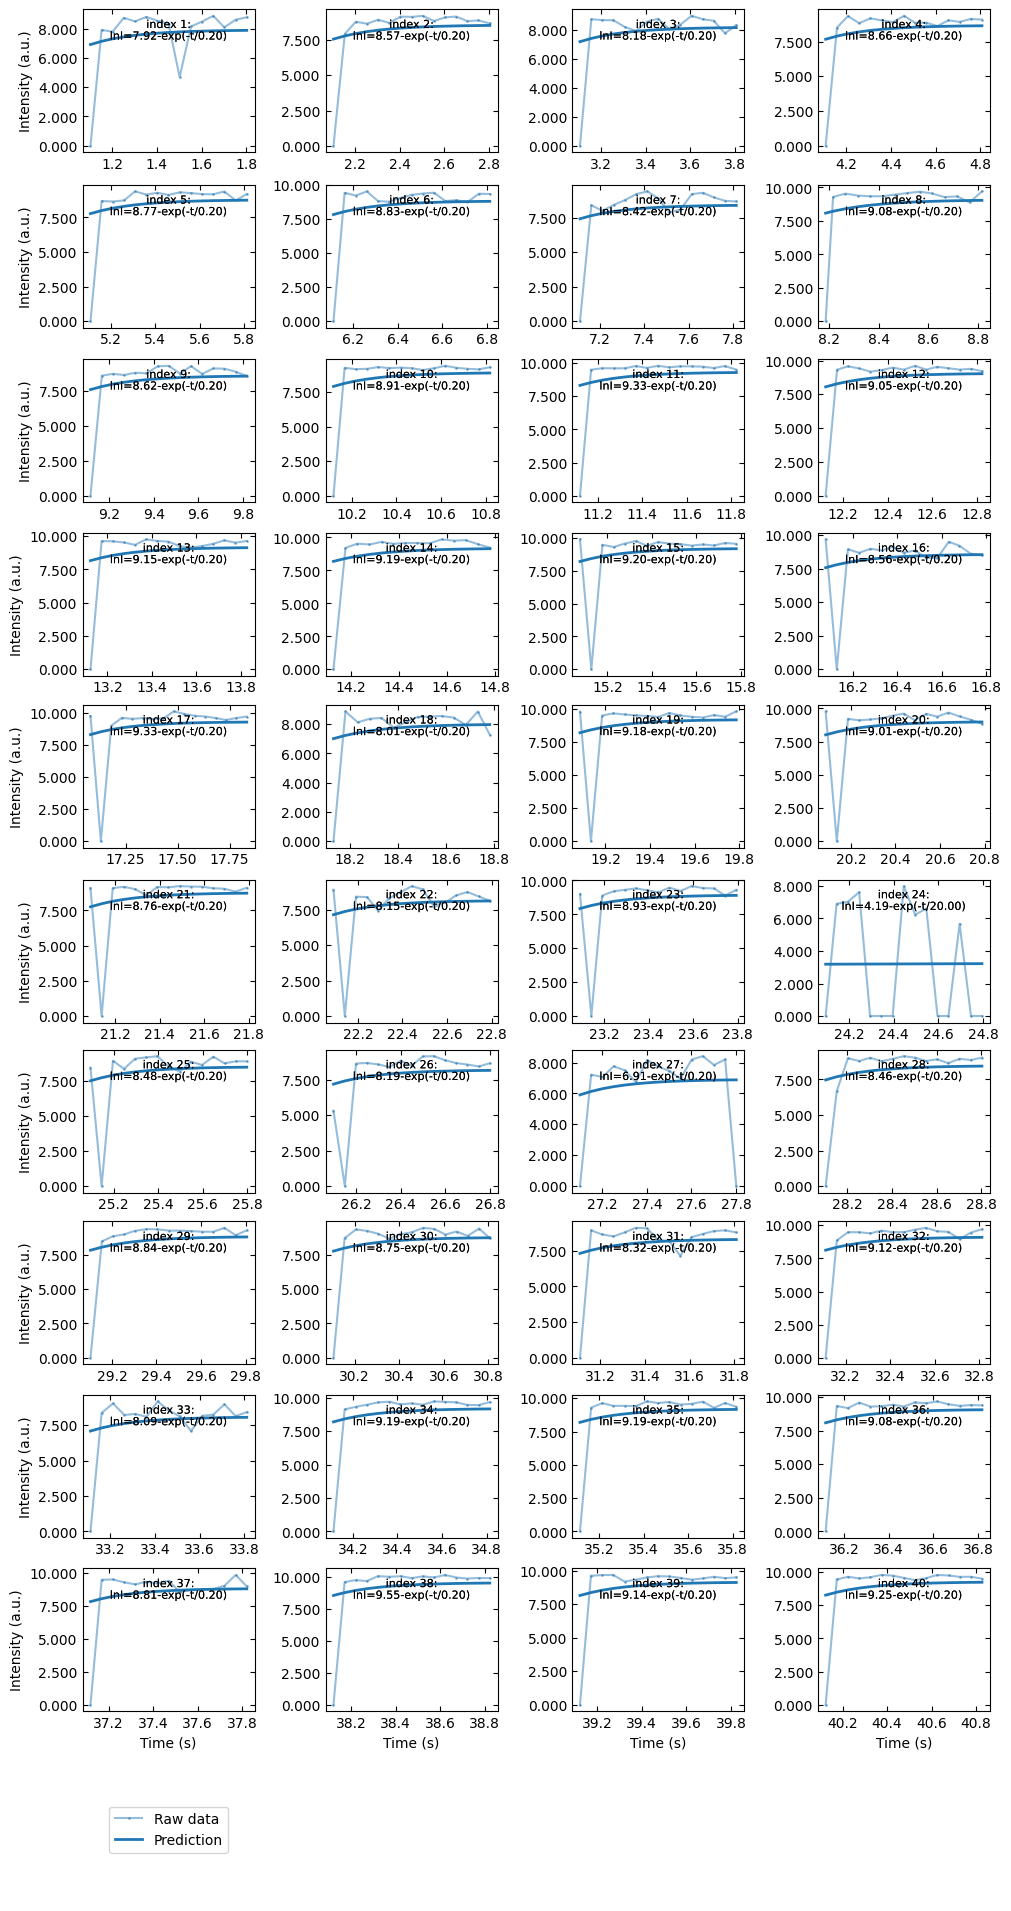

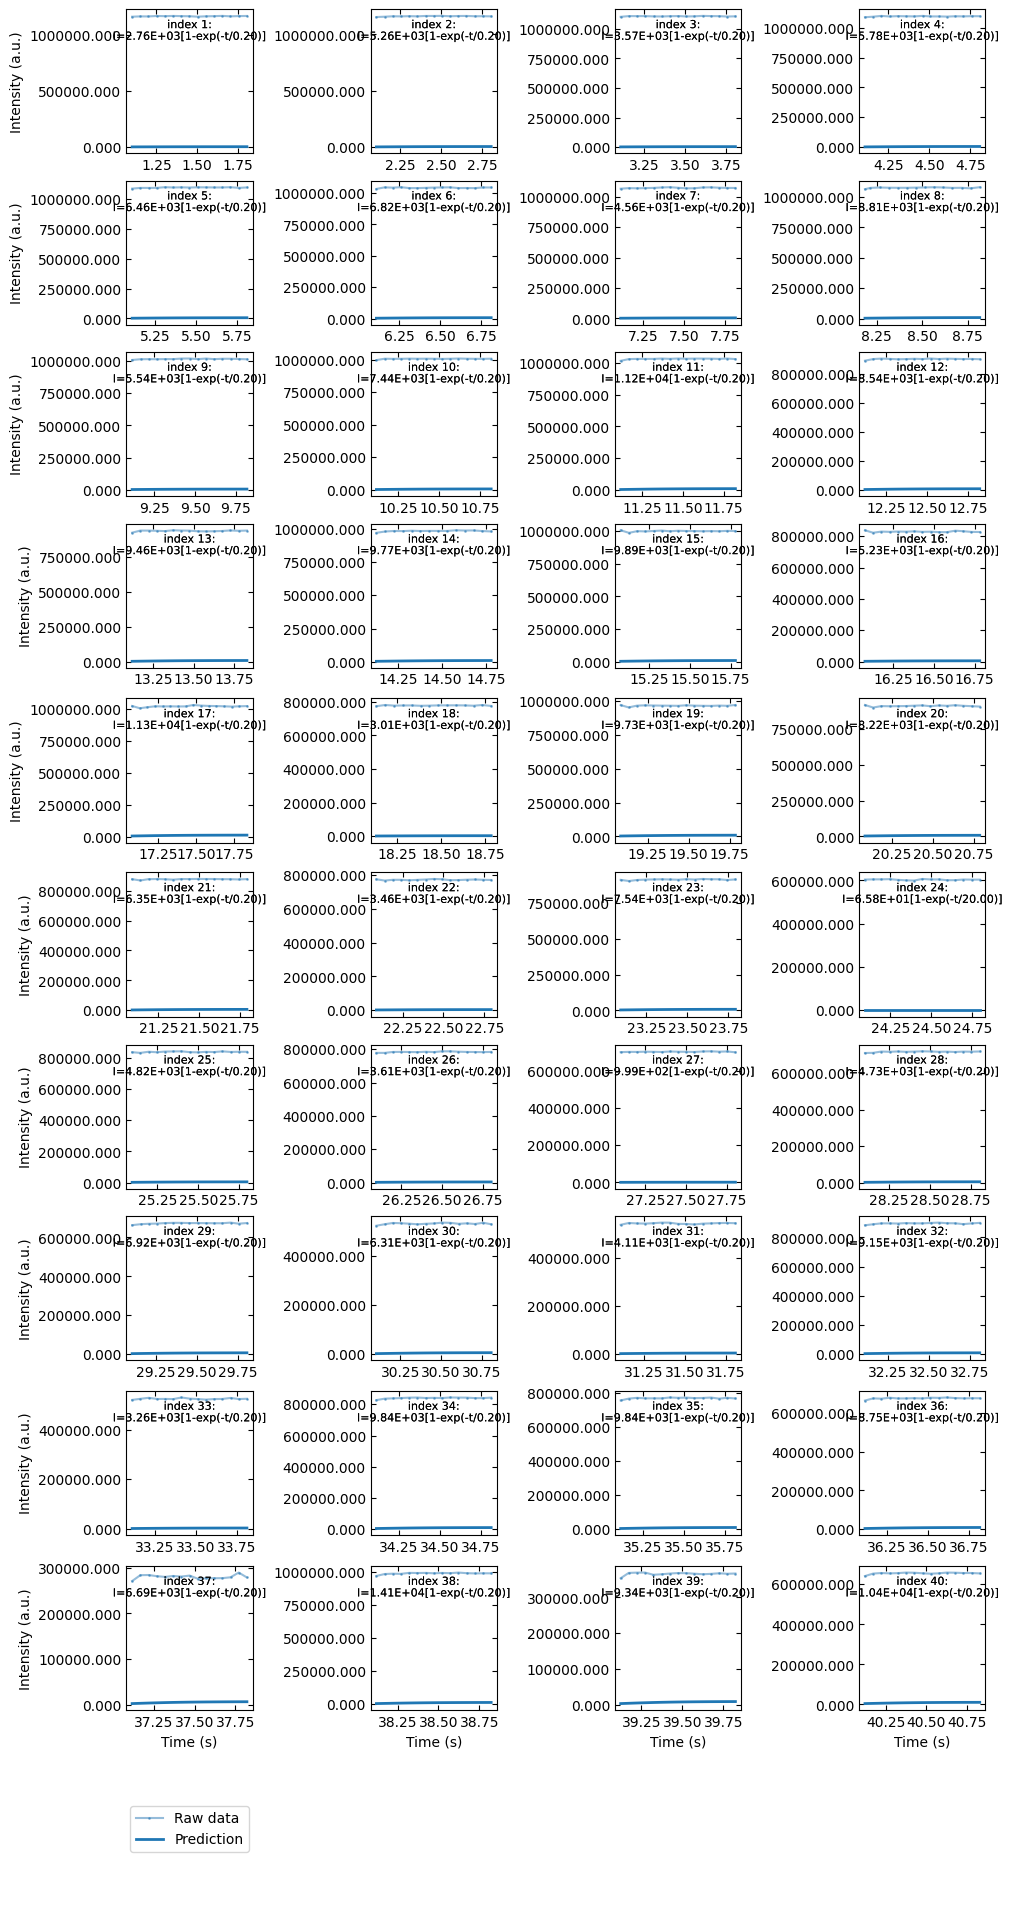

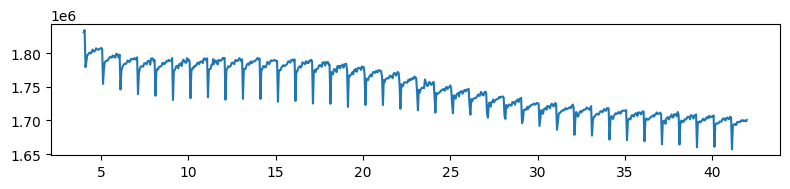

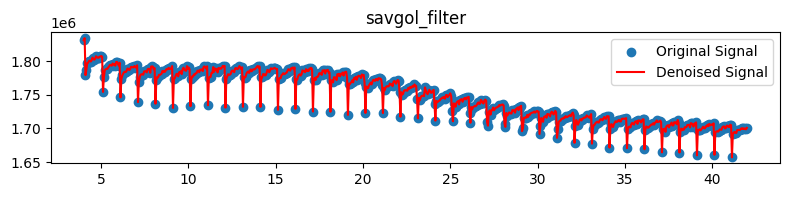

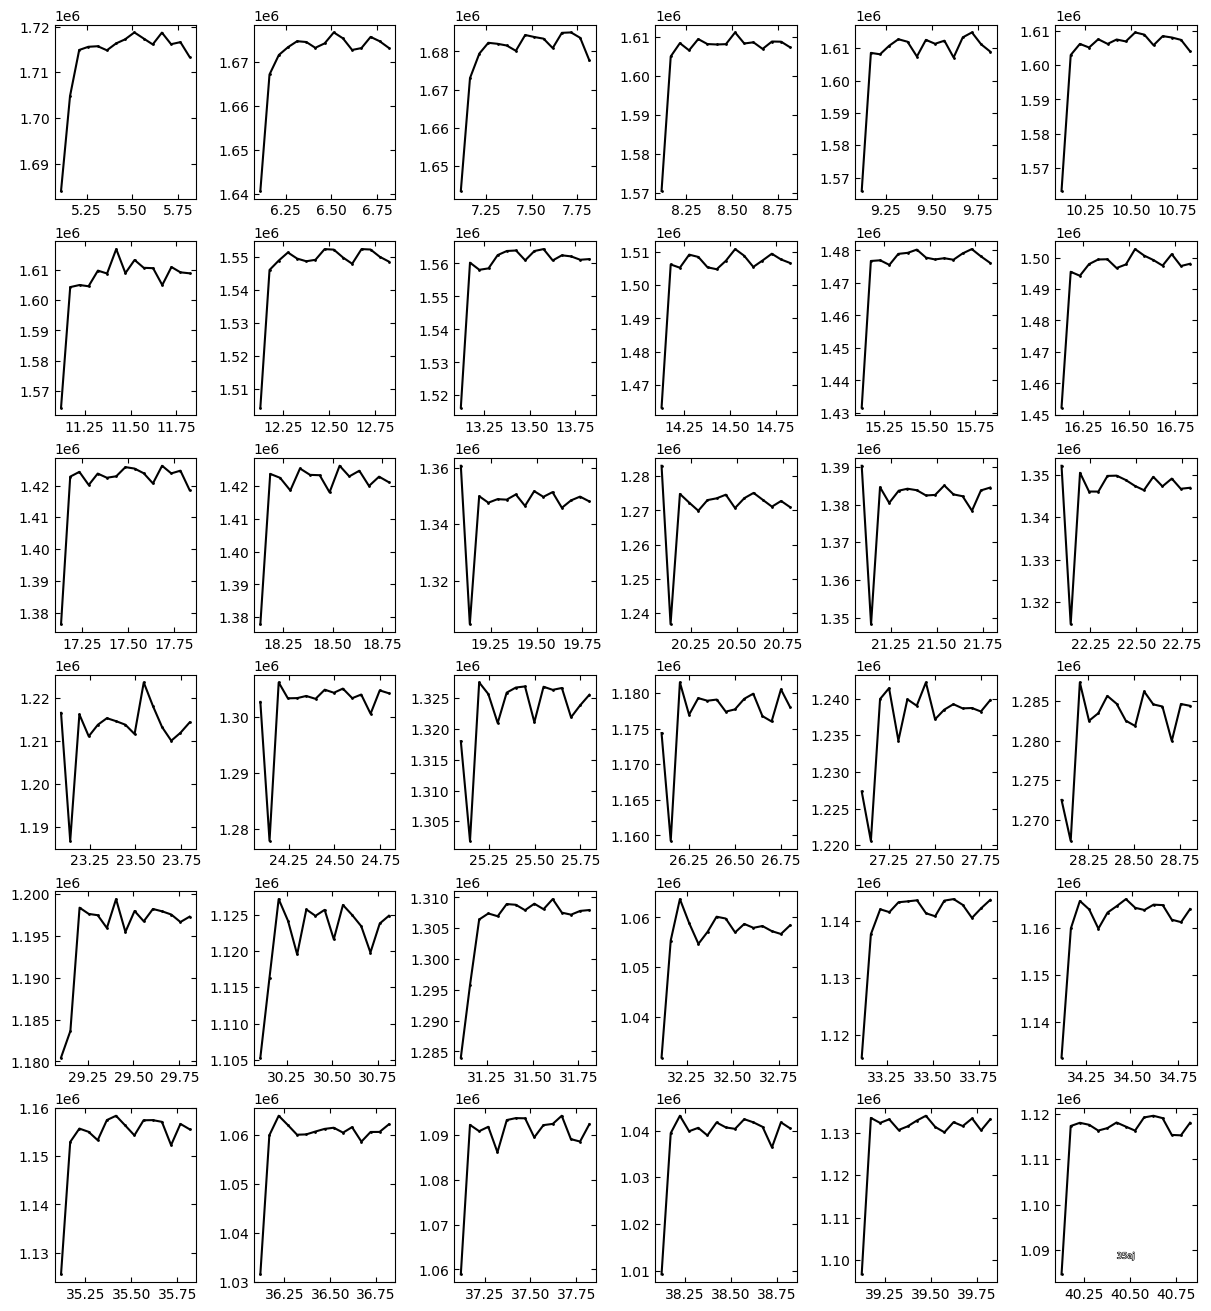

KeyboardInterrupt: 

In [67]:
expo_time = 50
camera_freq = 1000/expo_time
laser_freq = 1

denoise_params = {'savgol_window_order': (3, 2), 'pca_component': None, 'fft_cutoff_order':None, 'median_kernel_size':None}
curve_params = {'trim_first':0, 'tune_tail':False, 'convolve_step':5, 'prominence':10, 'mode':'valid', 'linear_ratio':0.8}
normalize_params = {'I_diff': None, 'unify':False, 'bounds':[0.2, 20], 'p_init':(15, 5), 'n_std':3}
viz_params = {'viz_denoise': True, 'viz_curves': True, 'viz_fittings': True, 'viz_ab': False}


# fit_settings = {'step_size':3, 'prominence':10, 'mode':'valid', 'length':None, 'savgol_window_order': (5, 3), 'pca_component': 3, 'I_diff': None, 
#                 'unify':False, 'bounds':[0.001, 1], 'p_init':[0.5, 0.4, 0.1], 'n_std':3, 'trim_first':0, 'tune_tail':False}


ranges_list = [(0, 42), (4, 42), (0, 40), (3, 42), (0, 42), (2, 42)]
files = glob.glob('./Saved_data/rheed_data/selected/*.txt')

for file, ranges in zip(files, ranges_list):
    data = np.loadtxt(file)
    data = select_range(data, *ranges)

    plt.subplots(1, 1, figsize=(8,2))
    plt.plot(data[:,0], data[:,1])
    plt.tight_layout()
    plt.show()

    b_list, tau_list, ys_log_fit, ys_fit, ys_log, labels_log, labels = analyze_rheed_data_txt(data, camera_freq, laser_freq, denoise_params, curve_params, normalize_params, viz_params)  

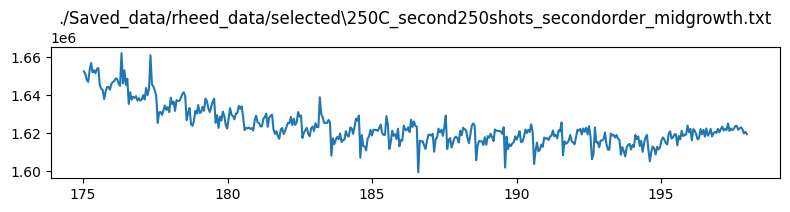

TypeError: detect_peaks() got an unexpected keyword argument 'step_size'

In [12]:
expo_time = 50
camera_freq = 1000/expo_time
laser_freq = 1
viz_curves=True
viz_fittings=True
viz_ab=False
fit_settings = {'step_size':3, 'prominence':10, 'mode':'valid', 'length':None, 'savgol_window_order': (5, 3), 'pca_component': 3, 'I_diff': None, 
                'unify':False, 'bounds':[0.001, 1], 'p_init':[0.5, 0.4, 0.1], 'n_std':3, 'trim_first':0, 'tune_tail':False}


ranges_list = [(175, 200), (0, 42), (0, 42), (0, 40), (0, 42), (0, 42), (0, 42)]
files = glob.glob('./Saved_data/rheed_data/selected/*.txt')

for file, ranges in zip(files, ranges_list):
    data = np.loadtxt(file)
    data = select_range(data, *ranges)
    plt.subplots(1, 1, figsize=(8,2))
    plt.plot(data[:,0], data[:,1])
    plt.tight_layout()
    plt.title(file)
    plt.show()

    sample_x, sample_y = data[:,0], data[:,1]

    step_size = fit_settings['step_size']
    prominence = fit_settings['prominence']
    mode = fit_settings['mode']

    x_peaks, xs, ys = detect_peaks(sample_x, sample_y, camera_freq=camera_freq, laser_freq=laser_freq, step_size=step_size, prominence=prominence, mode=mode)
    xs_sample, ys_sample = xs[::5], ys[::5]
    fig, axes = layout_fig(len(ys_sample), mod=6, figsize=(12,2*len(ys_sample)//6+1), layout='compressed')
    Viz.show_grid_plots(axes, xs_sample, ys_sample, labels=None, xlabel=None, ylabel=None, ylim=None, legend=None, color=None)

    
    fit_settings = {'step_size':3, 'prominence':10, 'mode':'valid', 'length':None, 'savgol_window_order': (3, 2), 'pca_component': 3, 'I_diff': None, 
                    'unify':False, 'bounds':[0.001, 1], 'p_init':[0.5, 0.4, 0.1], 'n_std':3, 'trim_first':0, 'tune_tail':False}

    xs, ys = process_rheed_data(xs, ys, length=fit_settings['length'], savgol_window_order=fit_settings['savgol_window_order'], 
                            pca_component=fit_settings['pca_component'])   

    fig, axes = layout_fig(len(ys), mod=6, figsize=(12,2*len(ys)//6+1), layout='compressed')
    Viz.show_grid_plots(axes, xs, ys, labels=None, xlabel=None, ylabel=None, ylim=None, legend=None, color=None)

    b_list, tau_list, ys_log_fit, ys_fit, ys_log, labels_log, labels = fit_tau(xs, ys, func='taylor_expansion')

    Viz.plot_fit_details(xs, ys_log, ys_log_fit, y3=None, labels=labels_log, figsize=(10, 1.8*len(xs)//4+1), mod=4, style='presentation', logscale=False)
    Viz.plot_fit_details(xs, ys, ys_fit, y3=None, labels=labels, figsize=(10, 1.8*len(xs)//4+1), mod=4, style='presentation', logscale=False)   